# Clustering using Zillow Data

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# general
import pandas as pd
import numpy as np

# explore/ stat
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan

# visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# default pandas decimal display formatting
pd.options.display.float_format='{:20,.2f}'.format

# supporting modules
from env import host, user, password
import acquire
import summarize
import prepare
import explore
import split_scale

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Acquire 
**Summarize the data to get an idea of how to best prepare for exploration.**

In [2]:
# acquire data, only retreive 261 > single residential family
#df = acquire.get_zillow_data().set_index("parcelid")
df = pd.read_csv('query_result.csv').set_index('parcelid')

In [3]:
# remove unit counts of two and three
df = df [(df.unitcnt != 2) | (df.unitcnt != 3)]

In [4]:
# change transaction to just month
df['transactiondate'] = pd.DatetimeIndex(df['transactiondate']).month

In [5]:
df.head()

,county,tax_rate,id,airconditioningtypeid,airconditioningdesc,architecturalstyletypeid,architecturalstyledesc,basementsqft,bathroomcnt,bedroomcnt,...,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,typeconstructiontypeid,typeconstructiondesc,censustractandblock,transactiondate,logerror,transactions
parcelid,,,,,,,,,,,,,,,,,,,,,
17052889,Ventura,0.01,1387261,nan,NaN,nan,NaN,nan,1.00,2,...,"376,000.00","5,672.48",NaN,nan,nan,NaN,"61,110,010,023,006.00",1,0.06,1
17110996,Ventura,0.01,43675,nan,NaN,nan,NaN,nan,2.50,3,...,"99,028.00","2,204.84",NaN,nan,nan,NaN,"61,110,050,041,163.00",1,0.01,1
17134185,Ventura,0.01,2490820,nan,NaN,nan,NaN,nan,2.00,4,...,"273,509.00","4,557.52",NaN,nan,nan,NaN,"61,110,055,042,000.00",1,0.06,1
17292247,Ventura,0.02,269618,nan,NaN,nan,NaN,nan,2.00,3,...,"24,808.00","1,450.06",NaN,nan,nan,NaN,"61,110,059,063,018.00",1,-0.42,1
17141654,Ventura,0.01,74982,nan,NaN,nan,NaN,nan,3.00,4,...,"126,138.00","4,139.18",NaN,nan,nan,NaN,"61,110,053,061,004.00",1,-0.02,1


In [6]:
df.transactiondate.unique()

array([1, 7, 6, 8, 3, 4, 5, 2, 9])

In [7]:
df.shape

(52169, 71)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tax_rate,"52,164.00",0.01,0.01,0.00,0.01,0.01,0.01,0.82
id,"52,169.00","1,496,932.46","859,434.15",349.00,"757,739.00","1,500,051.00","2,241,574.00","2,982,270.00"
airconditioningtypeid,"13,605.00",2.44,3.85,1.00,1.00,1.00,1.00,13.00
architecturalstyletypeid,70.00,7.10,2.67,2.00,7.00,7.00,7.00,21.00
basementsqft,47.00,678.98,711.83,38.00,263.50,512.00,809.50,"3,560.00"
bathroomcnt,"52,169.00",2.31,1.02,1.00,2.00,2.00,3.00,18.00
bedroomcnt,"52,169.00",3.31,0.93,1.00,3.00,3.00,4.00,14.00
buildingclasstypeid,0.00,nan,nan,nan,nan,nan,nan,nan
buildingclassdesc,0.00,nan,nan,nan,nan,nan,nan,nan
buildingqualitytypeid,"33,628.00",6.27,1.72,1.00,5.00,6.00,8.00,12.00


In [9]:
# Use summarize.py to display all summaries for all features and get a full picture of the data.
#summarize.df_summary(df)

##### From this summary, we are able to see that we have a lot of missing values and data types that aren't what we would want them to be.

**Task 1:** Summarize the null values and decide how to handle them, either remove or impute.

**Task 2:** Decide on appropiate data type for each column and make changes as neccesary.

,num_rows_missing,pct_rows_missing
finishedsquarefeet13,52169,1.00
buildingclasstypeid,52169,1.00
buildingclassdesc,52169,1.00
finishedsquarefeet15,52169,1.00
storydesc,52122,1.00
storytypeid,52122,1.00
basementsqft,52122,1.00
yardbuildingsqft26,52106,1.00
architecturalstyletypeid,52099,1.00
architecturalstyledesc,52099,1.00


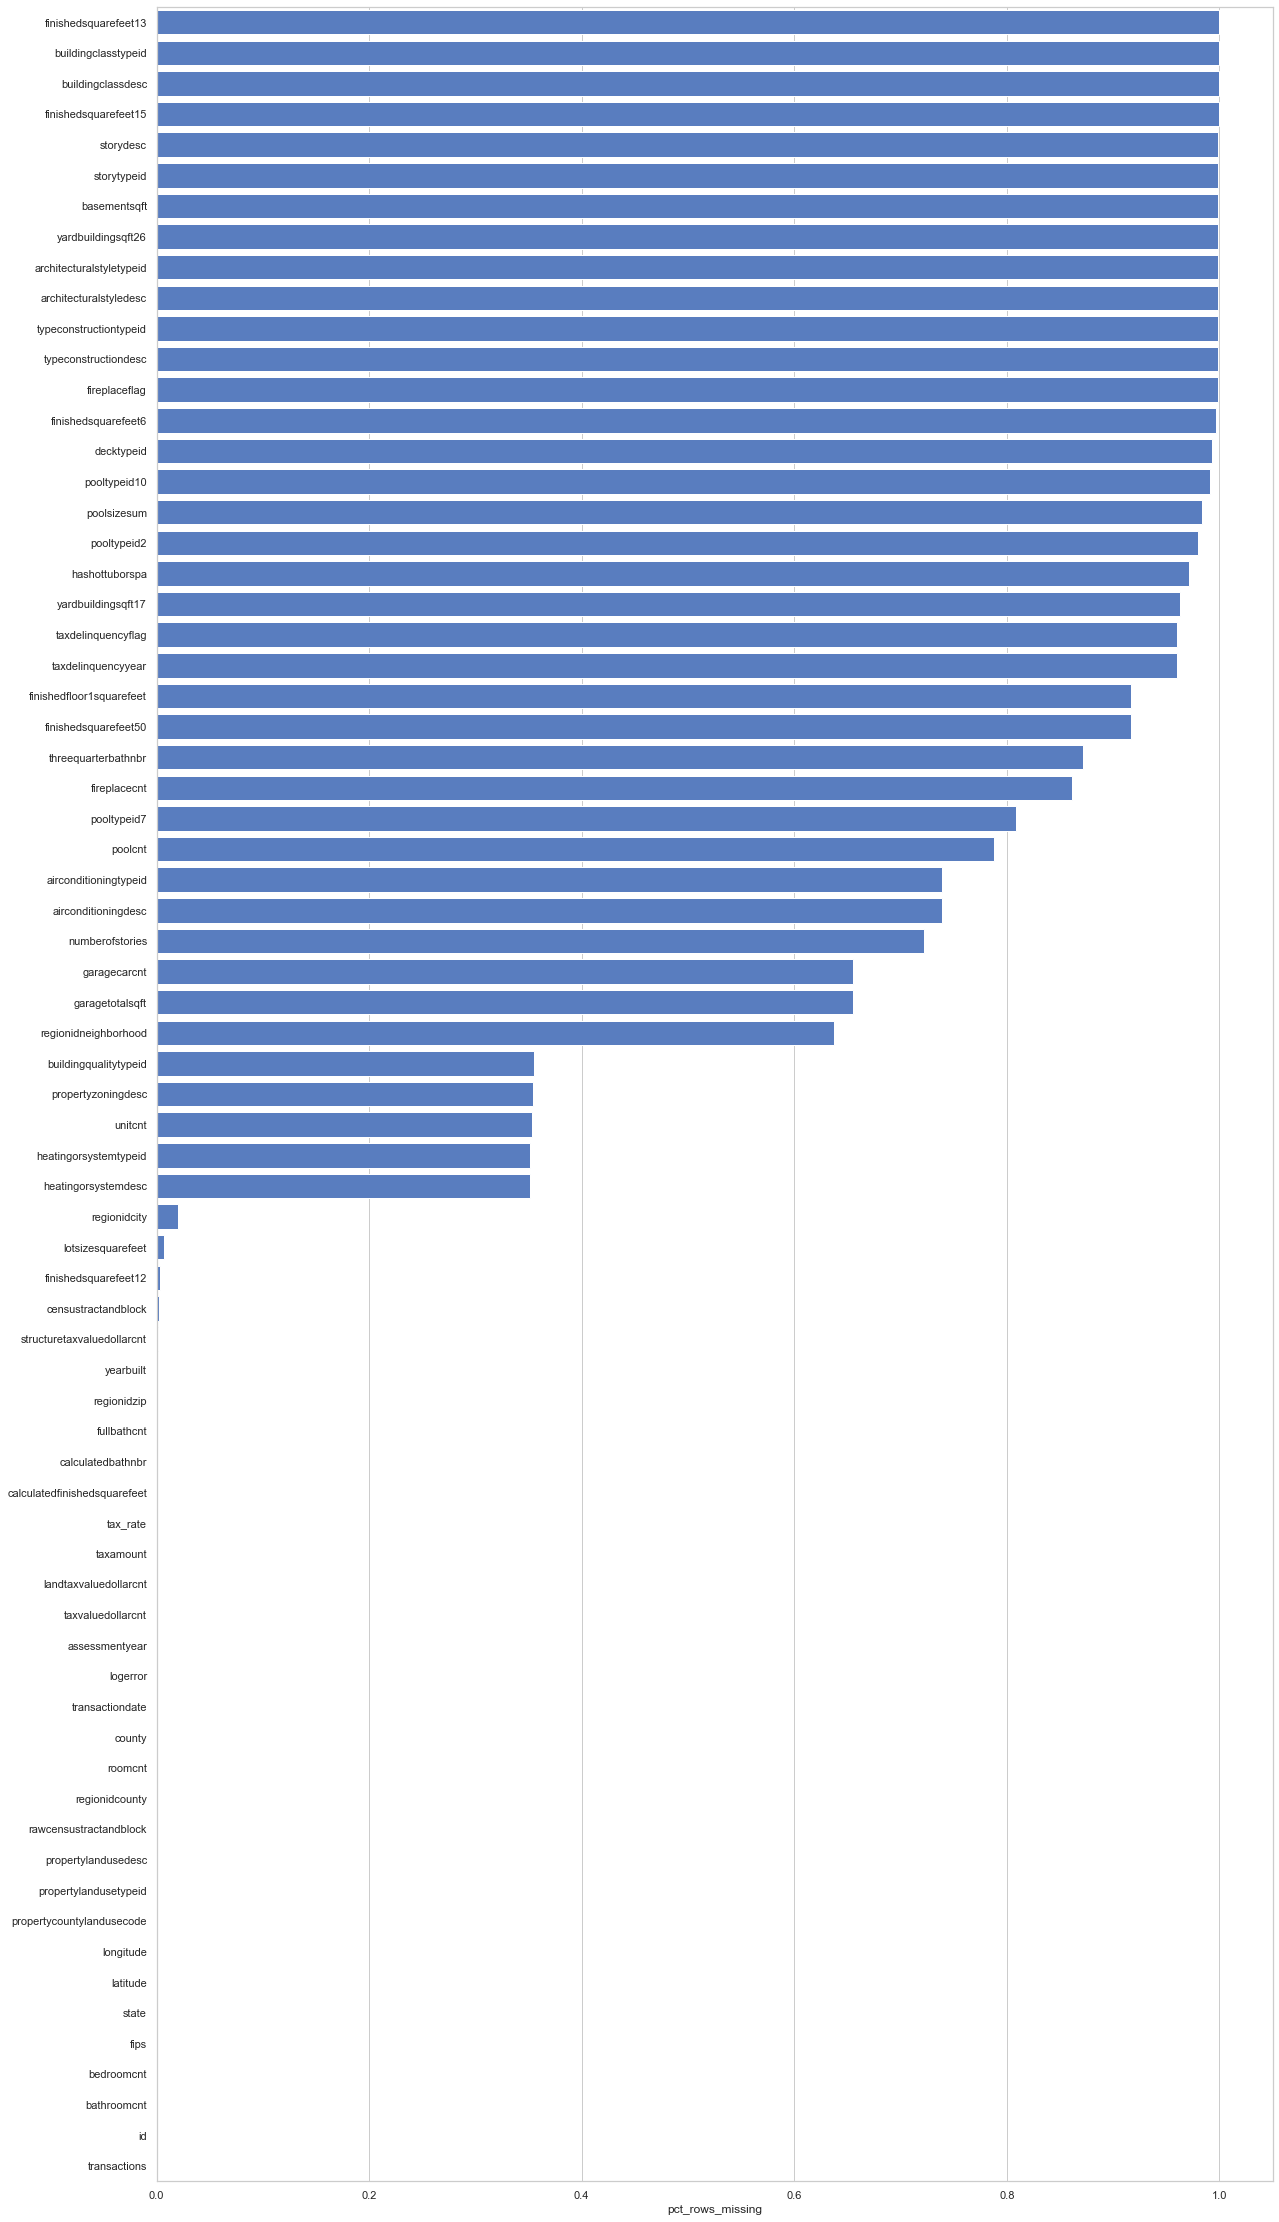

In [10]:
# This dataframe shows the number of missing rows and the percentage rows missing from each column.
summarize.nulls_by_col(df)

In [11]:
# This dataframe shows  the number of missing columns, percentage of missing columns, and the ID of the column.
summarize.nulls_by_row(df)

,num_cols_missing,pct_cols_missing,parcelid
0,23,32.3943661971831,2
1,24,33.80281690140845,12
2,25,35.2112676056338,11
3,26,36.61971830985916,30
4,27,38.028169014084504,177
5,28,39.436619718309856,389
6,29,40.845070422535215,2527
7,30,42.25352112676056,2194
8,31,43.66197183098591,5986
9,32,45.07042253521127,8880


##### Now we will use a function to deal with missing values in the columns and the rows. If a row has more than 50% nulls, they will be removed. If a columns has more than 75% nulls, they will be removed.

In [12]:
df = prepare.handle_missing_values(df, prop_required_column = .5, prop_required_row = .75)

After using this function, we didn't lose any rows, but we lost a lot of columns.

In [13]:
df.shape

(52168, 37)

In [14]:
# summarize.report_remain_nulls_by_col(df, num_rows_of_interest) to show the remaining missing rows and the percentage. From this, we will decide if we want to drop or impute.
summarize.report_remain_nulls_by_col(df, 200)

,num_rows_missing,pct_rows_missing
buildingqualitytypeid,18540,0.36
heatingorsystemtypeid,18344,0.35
heatingorsystemdesc,18344,0.35
lotsizesquarefeet,354,0.01
propertyzoningdesc,18478,0.35
regionidcity,1028,0.02
unitcnt,18450,0.35


In [15]:
# 1st feature construction
# Adjust the 'yearbuilt' column to work with 'age'. This will make it easier to to work with.
df['age'] = 2017 - df.yearbuilt

In [16]:
df.loc[:,'latitude'] = df.loc[:,'latitude']/1e6
df.loc[:,'longitude'] = df.loc[:,'longitude']/1e6

In [17]:
# These are the columns we will drop either because we do not need them or they are duplicates.
df = df.drop(columns = ['yearbuilt','propertylandusedesc','propertylandusetypeid','fullbathcnt','state','calculatedbathnbr','id','finishedsquarefeet12', 'buildingqualitytypeid', 'heatingorsystemtypeid', 'heatingorsystemdesc', 'propertyzoningdesc', 'propertyzoningdesc', 'unitcnt'])

In [18]:
df.shape

(52168, 25)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b94bfd0>,
      dtype=object)

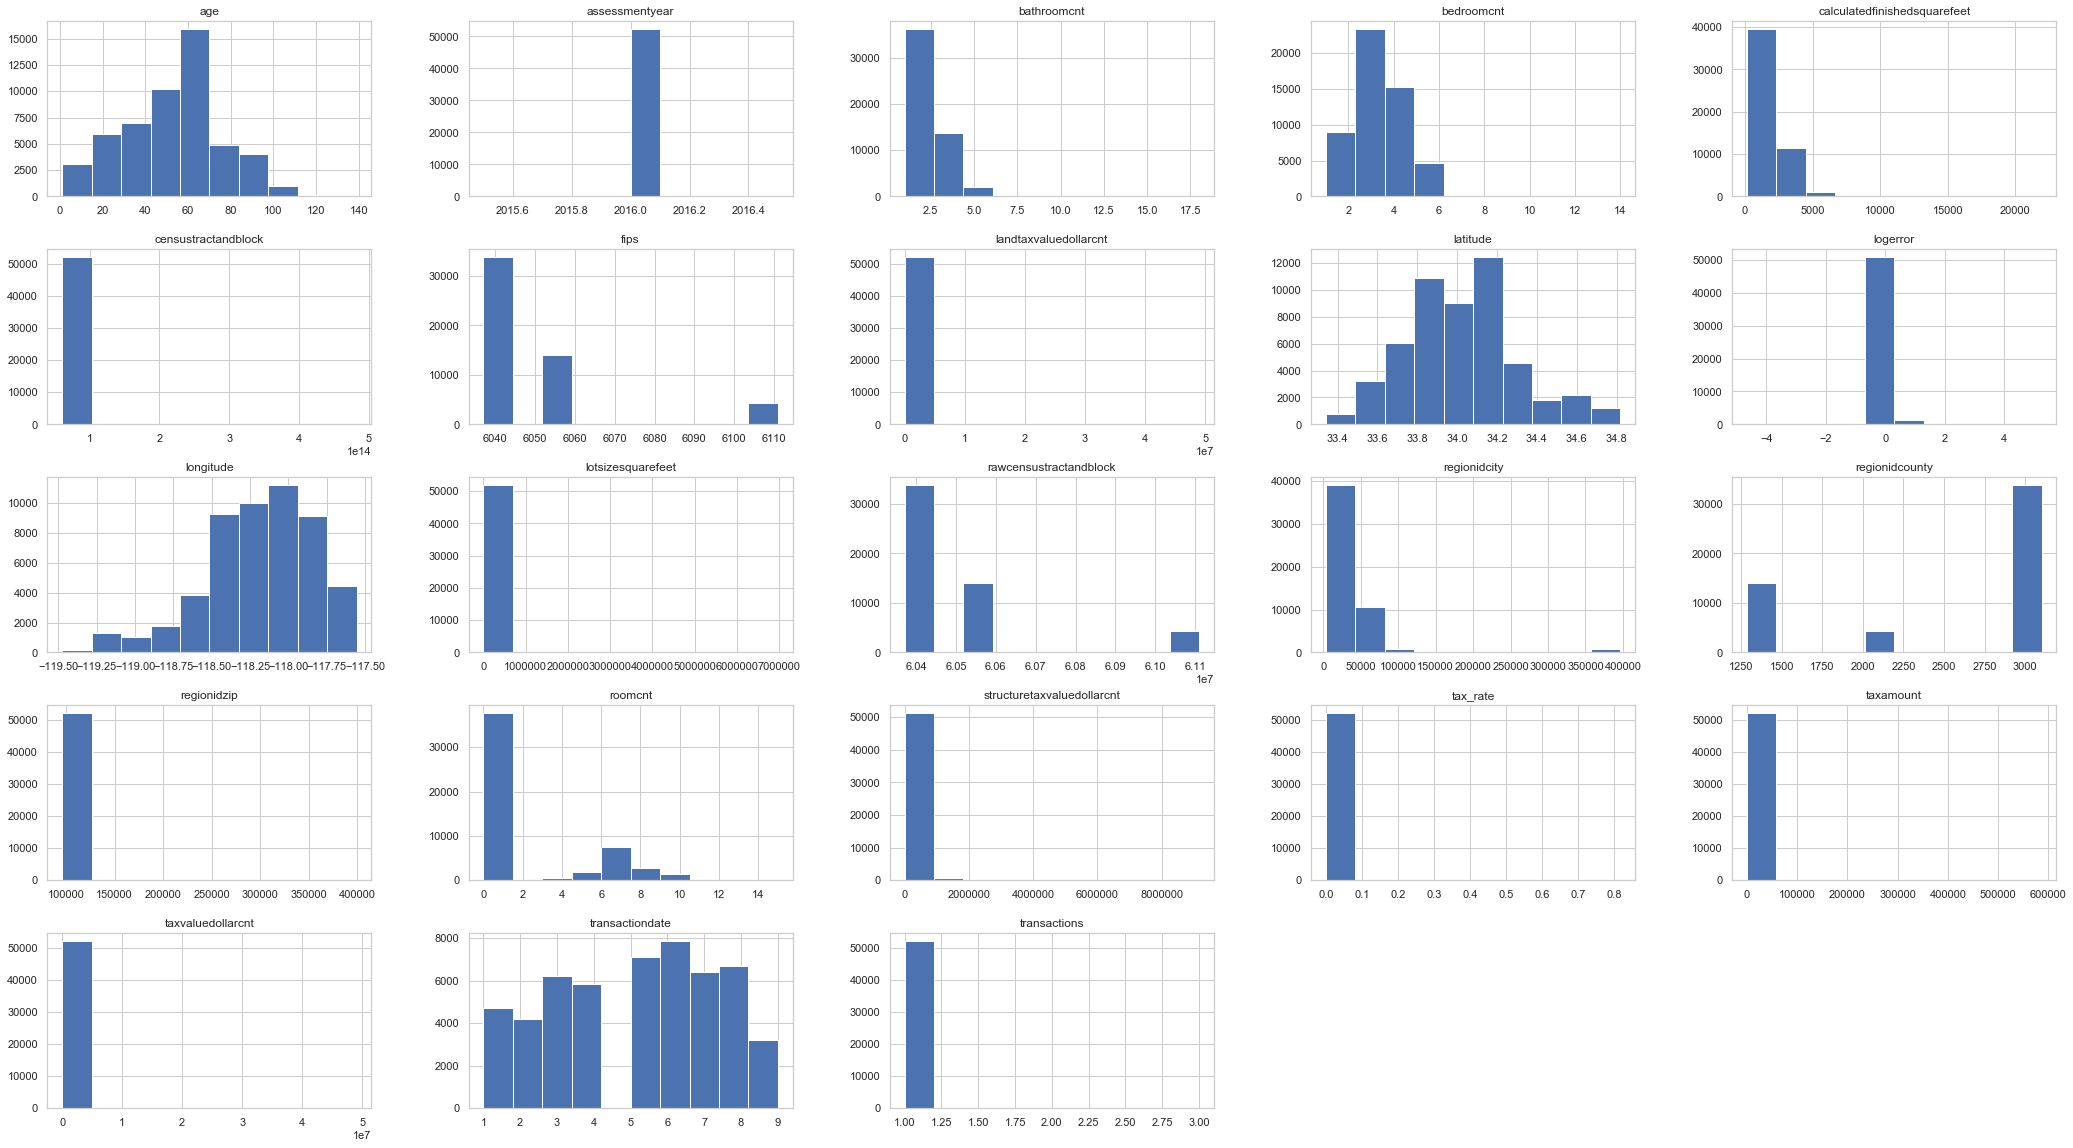

In [19]:
# Look at the distribution of the remaining features to see if there are any outliers.
# Identify outliers visually
df.hist(figsize=(36,20))

In [20]:
col_out = ["tax_rate", "bathroomcnt", "bedroomcnt","calculatedfinishedsquarefeet", "lotsizesquarefeet", "roomcnt", "taxamount"]

In [21]:
def remove_outliers_iqr(df, col):
    #for col in columns:
        #q75, q25 = np.percentile(df[col], [75,25])

    q1, q3 = df[col].quantile([.25, .75])
    iqr = q3 - q1
    ub = q3 + 3 * iqr
    lb = q1 - 3 * iqr

    df = df[df[col] <= ub]
    df = df[df[col] >= lb]
    return df

In [22]:
# Remove outliers in each of the following columns.
df = remove_outliers_iqr(df, "tax_rate")
df = remove_outliers_iqr(df, "bathroomcnt")
df = remove_outliers_iqr(df, "bedroomcnt")
df = remove_outliers_iqr(df, "calculatedfinishedsquarefeet")
df = remove_outliers_iqr(df, "lotsizesquarefeet")
df = remove_outliers_iqr(df, "roomcnt")
df = remove_outliers_iqr(df, "taxamount")

In [23]:
df.shape

(44749, 25)

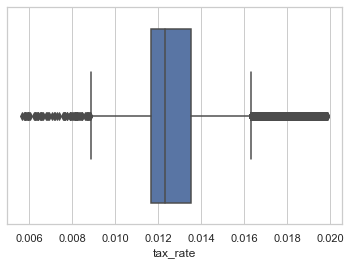

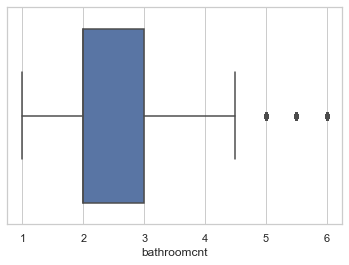

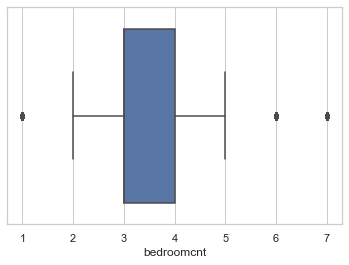

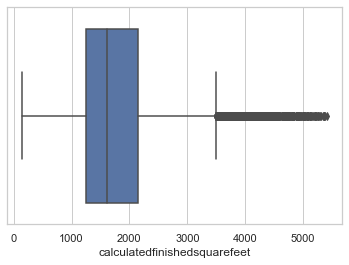

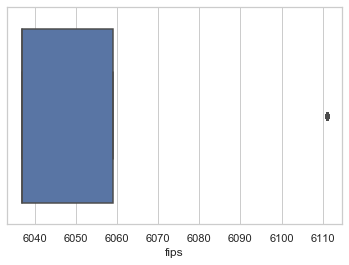

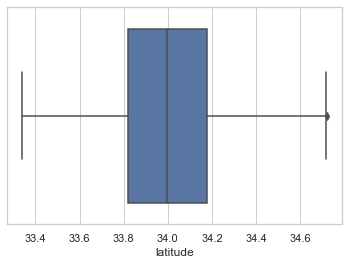

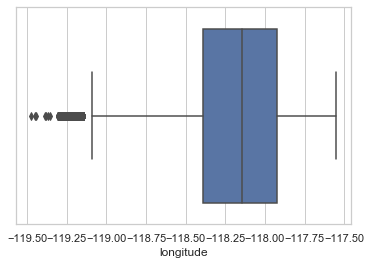

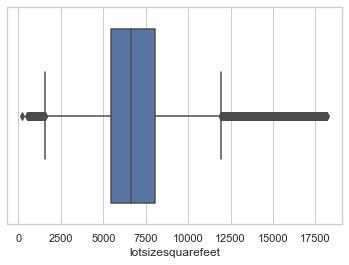

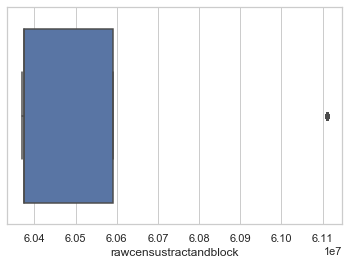

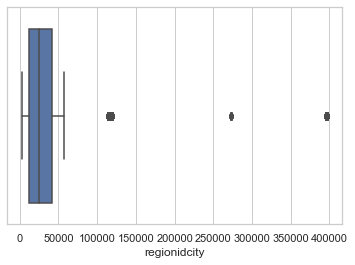

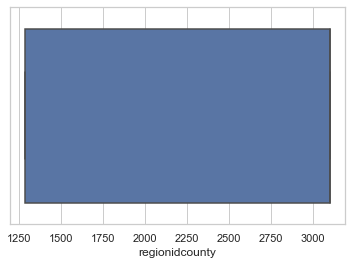

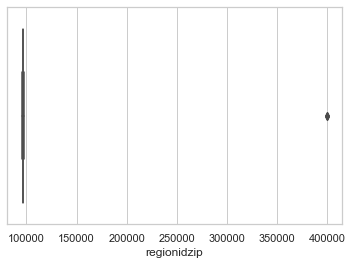

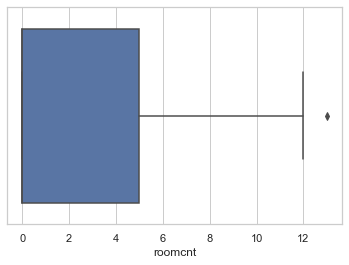

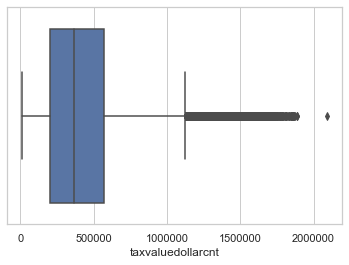

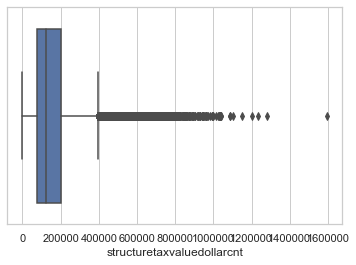

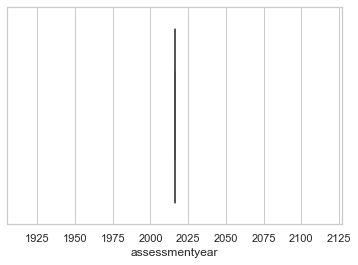

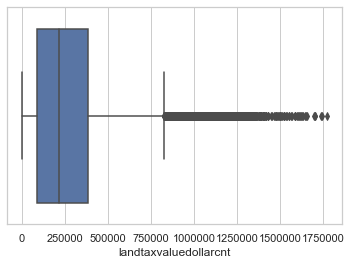

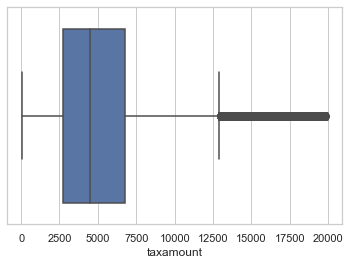

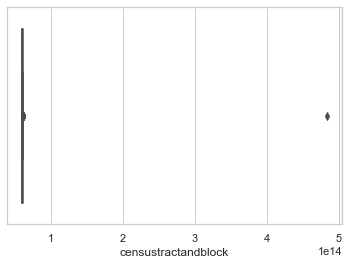

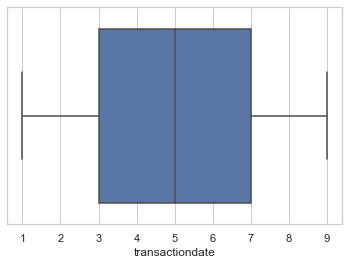

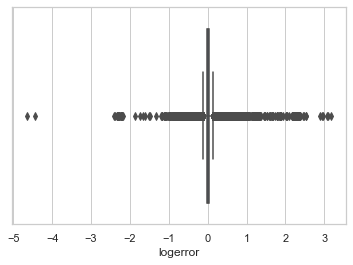

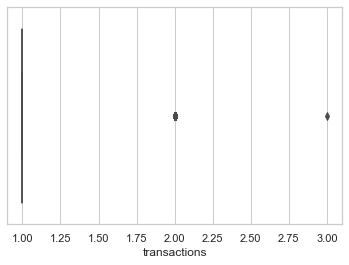

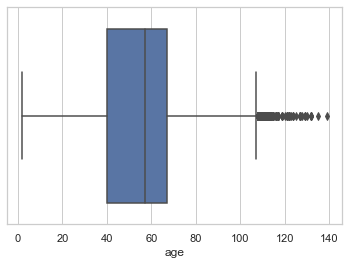

In [24]:
# Validate outlier removal and visualize the columns with boxplots
explore.df_feature_box(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a243f3780>,
      dtype=object)

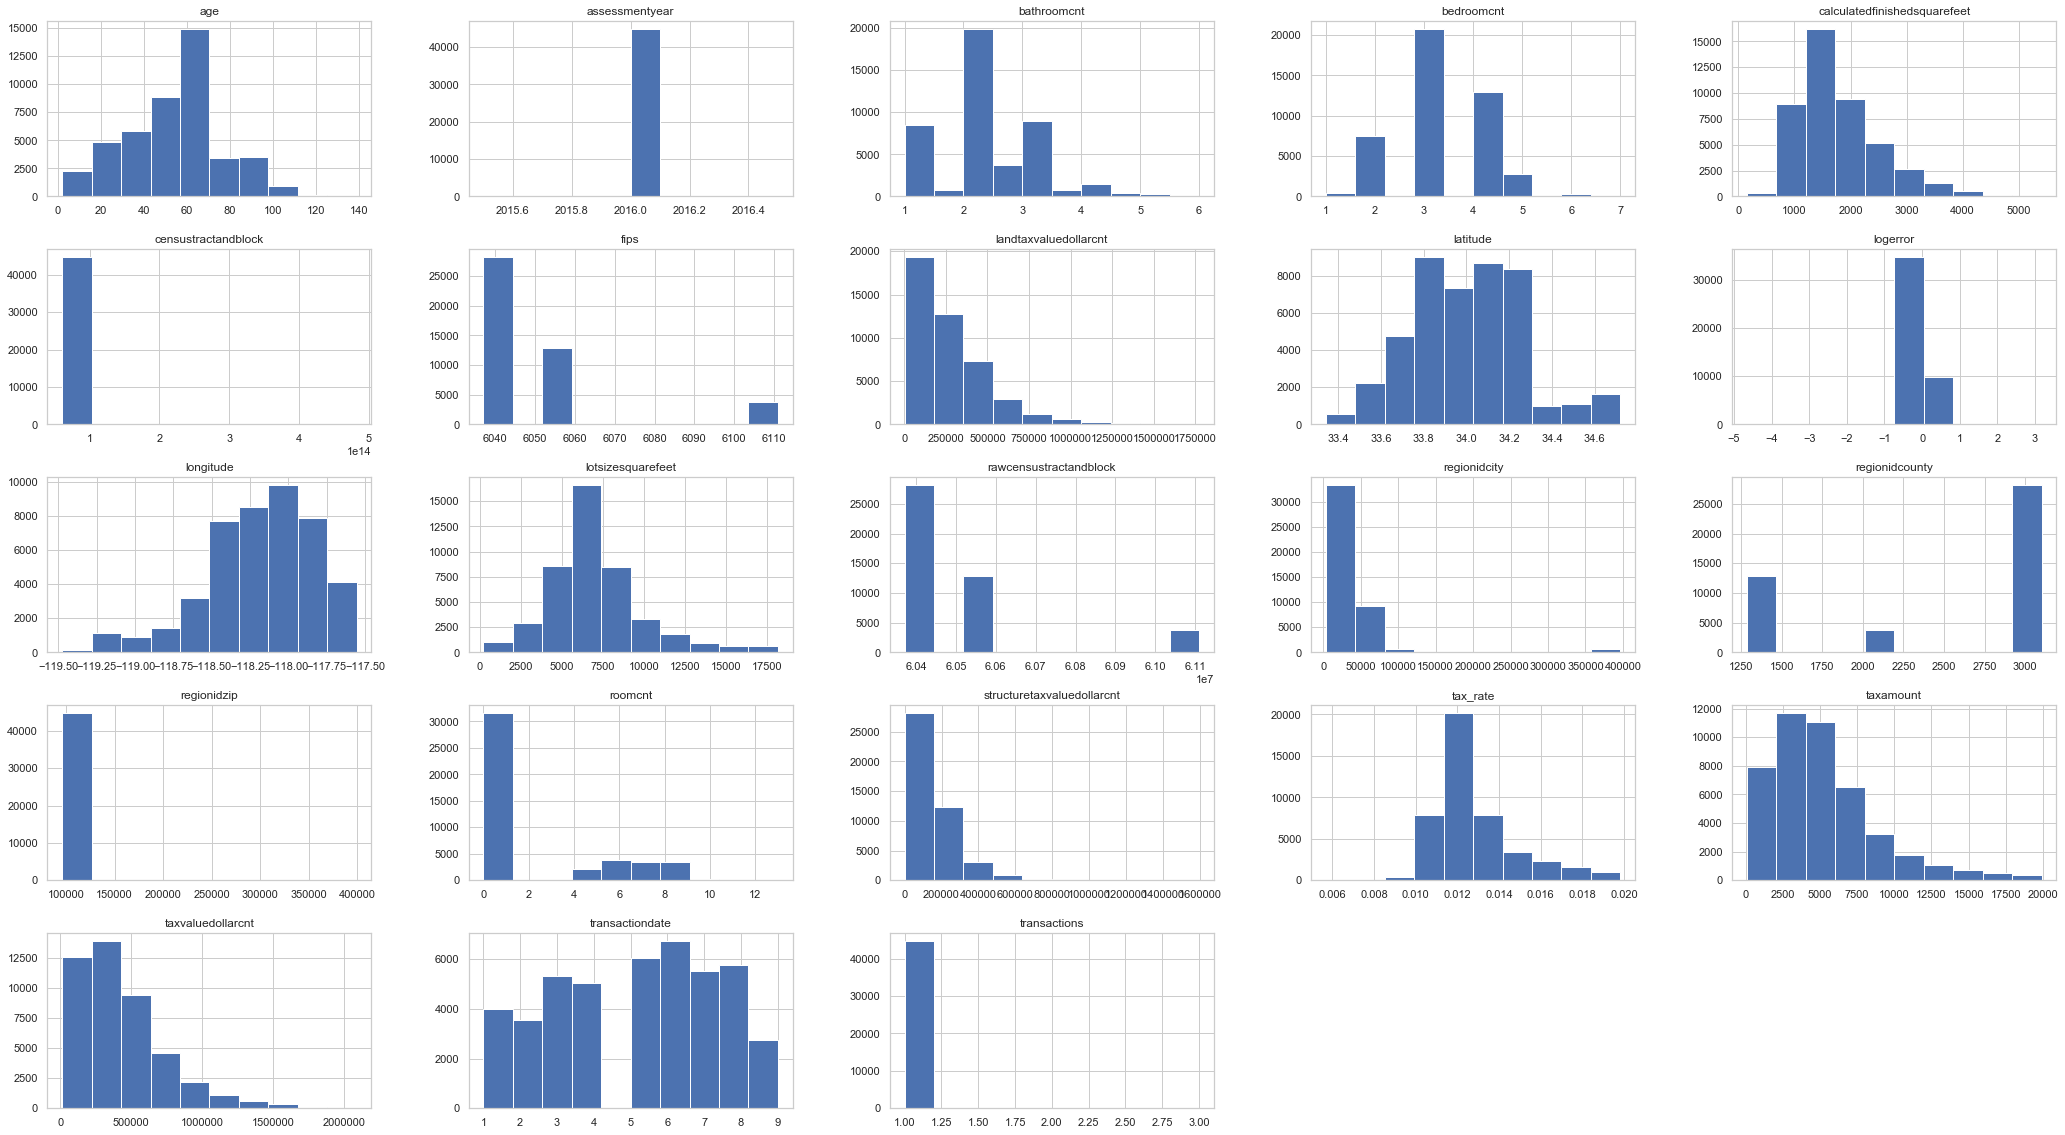

In [25]:
df.hist(figsize=(36,20))

##### After handling the outliers, we will now split our data into train and test and then impute the remaining missing values, filling them with either the mean or mode.

In [26]:
col_impute_mean = ['tax_rate', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 
                   'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

col_impute_mode = ['regionidcity', 'regionidzip','censustractandblock']

In [27]:
train, test = prepare.split_my_data(df)

In [28]:
train, test = prepare.impute(train, test, "mean", col_impute_mean)
train, test = prepare.impute(train, test, "most_frequent", col_impute_mode)

In [29]:
# Lost some more rows due to dropping outliers
print(df.shape)
print(train.shape)
print(test.shape)

(44749, 25)
(35087, 25)
(8772, 25)


##### Now that all of the missing values have been handled, we will change any dtypes we feel necessary to change,

In [30]:
df["transactions"] = df.transactions.astype("float")

df["bedroomcnt"] = df.bedroomcnt.astype("int")
df["roomcnt"] = df.roomcnt.astype("int")

df["fips"] = df.fips.astype("object")
df["regionidcity"] = df.regionidcity.astype("object")
df["regionidcounty"] = df.regionidcounty.astype("object")
df["regionidzip"] = df.regionidzip.astype("object")
df["assessmentyear"] = df.assessmentyear.astype("object")

train["transactions"] = train.transactions.astype("float")

train["bedroomcnt"] = train.bedroomcnt.astype("int")
train["roomcnt"] = train.roomcnt.astype("int")

train["fips"] = train.fips.astype("object")
train["regionidcity"] = train.regionidcity.astype("object")
train["regionidcounty"] = train.regionidcounty.astype("object")
train["regionidzip"] = train.regionidzip.astype("object")
train["assessmentyear"] = train.assessmentyear.astype("object")

test["transactions"] = test.transactions.astype("float")

test["bedroomcnt"] = test.bedroomcnt.astype("int")
test["roomcnt"] = test.roomcnt.astype("int")

test["fips"] = test.fips.astype("object")
test["regionidcity"] = test.regionidcity.astype("object")
test["regionidcounty"] = test.regionidcounty.astype("object")
test["regionidzip"] = test.regionidzip.astype("object")
test["assessmentyear"] = test.assessmentyear.astype("object")

In [31]:
print(df.shape)
print(train.shape)
print(test.shape)

(44749, 25)
(35087, 25)
(8772, 25)


##### Scaling the data

In [32]:
mm = ['latitude','longitude']
std = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet','age']

In [33]:
scaler, train_scaled, test_scaled = split_scale.standard_scaler\
(train[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet','age']],\
test[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet','age']])

train1 = train.drop(columns = std)
train1 = train1.join(train_scaled)
test1 = test.drop(columns = std)
test1 = test1.join(test_scaled)

In [34]:
scaler, train_scaled, test_scaled = split_scale.min_max_scaler\
(train[['latitude','longitude']], test[['latitude','longitude']])

train1 = train1.drop(columns = mm)
train1 = train1.join(train_scaled)
test1 = test1.drop(columns = mm)
test1 = test1.join(test_scaled)

In [35]:
train1.head()

,county,tax_rate,fips,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,taxvaluedollarcnt,...,transactiondate,logerror,transactions,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,age,latitude,longitude
parcelid,,,,,,,,,,,,,,,,,,,,,
14115188,Orange,0.01,6059,122,"60,590,871.06","16,764.00",1286,"97,021.00",6,"476,345.00",...,8,-0.01,1.00,-0.21,-0.29,-0.59,-0.16,0.18,0.35,0.81
17202081,Ventura,0.01,6111,1111,"61,110,076.10","25,974.00",2061,"97,097.00",7,"269,973.00",...,7,0.07,1.00,0.39,-0.29,-0.01,-0.05,-1.13,0.67,0.30
11867910,Los Angeles,0.01,6037,0100,"60,374,808.04","50,677.00",3101,"96,531.00",0,"92,656.00",...,5,-0.02,1.00,-1.42,-1.43,-1.34,0.21,1.80,0.55,0.69
12888153,Los Angeles,0.01,6037,0100,"60,374,024.02","20,008.00",3101,"96,506.00",0,"288,484.00",...,4,0.03,1.00,-1.42,-0.29,-0.91,-0.27,0.68,0.51,0.89
17055276,Ventura,0.01,6111,1110,"61,110,009.03","13,091.00",2061,"97,099.00",6,"820,000.00",...,6,0.09,1.00,-0.82,-1.43,-0.62,1.22,1.58,0.80,0.11


**The 'heatingorsystemtypeid', 'heatingorsystemdesc' and 'propertyzoningdesc' have significantly less values than the other values, but not so much so that they were removed with the function. We will just take note of this if we need to reference that later on.**

### Explore

In [36]:
def df_feature_dist(df):
    # get a list of columns where content is number
    features_num = list(df.select_dtypes(np.number).columns)
    for feature in features_num:
        sns.distplot(df[feature].dropna())
        plt.show()

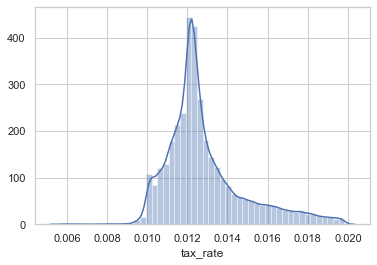

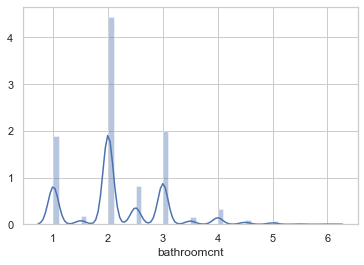

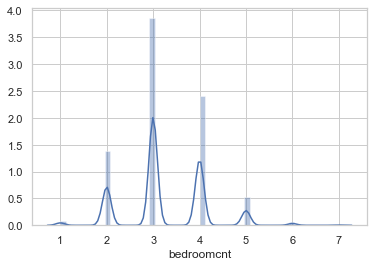

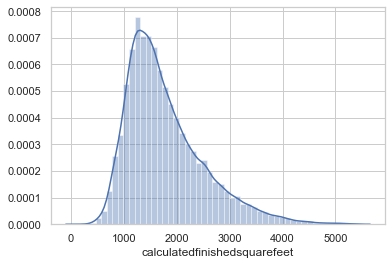

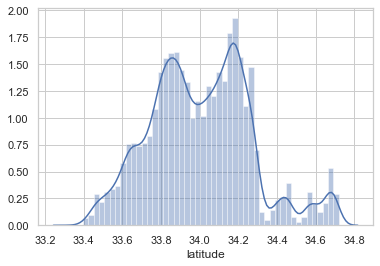

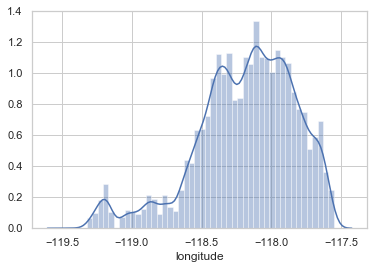

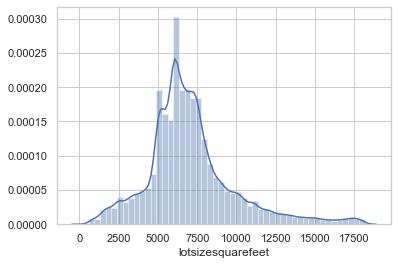

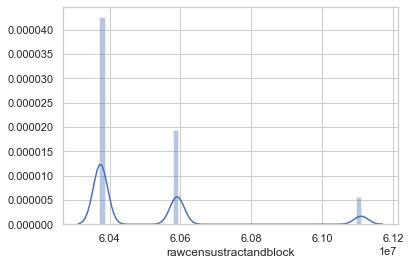

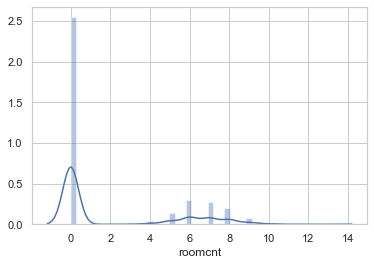

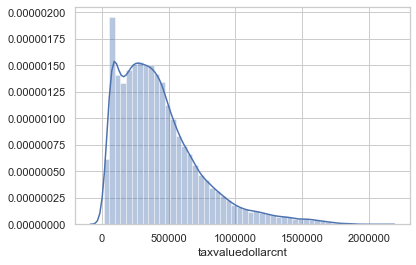

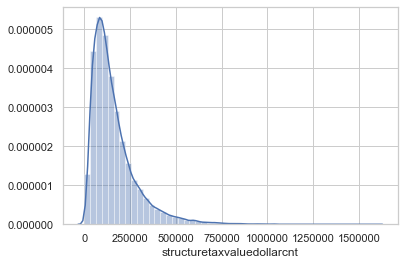

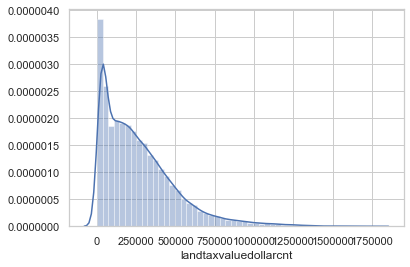

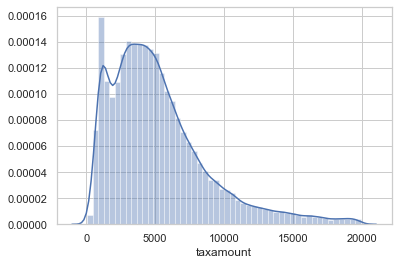

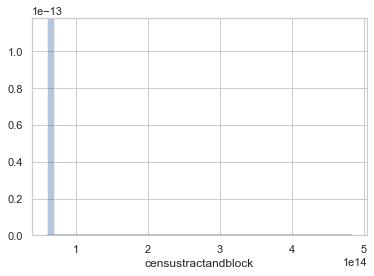

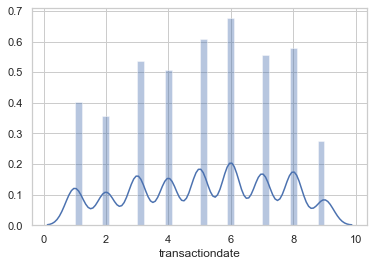

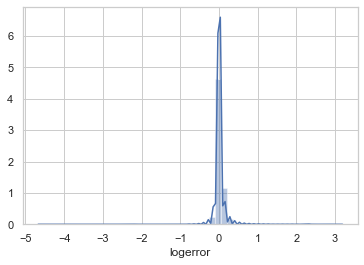

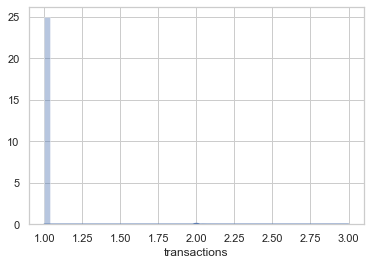

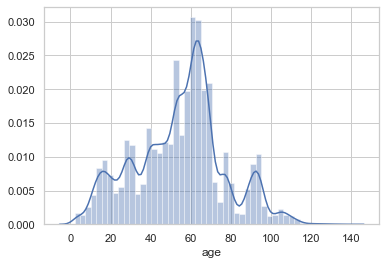

In [37]:
# Look at the distribution of features after the prep.
df_feature_dist(df)

**NOTES ABOUT FEATURES**
- calculatedfinishedsquarefeet max = 5408 seems really big
    think twice about what does calculatedfinishedsquarefeet truly means
    
    
- lotsizesquarefeet also really big, how does that compare to calc finished?

- roomcnt, bathroomcnt, bedroomcnt

- latitude and longitude need to be processed (make normal by /10^6?)

- rawcensustractandblock, censustractandblock, regionidcity, regionidcounty , regionidzip
    how to use? what value do these col bring?

- taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, taxamount

- assessmentyear > double check year

- age

- transactions???

- logerror > TARGET

In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.describe())

                  tax_rate          bathroomcnt           bedroomcnt  \
count            44,749.00            44,749.00            44,749.00   
mean                  0.01                 2.19                 3.25   
std                   0.00                 0.84                 0.88   
min                   0.01                 1.00                 1.00   
25%                   0.01                 2.00                 3.00   
50%                   0.01                 2.00                 3.00   
75%                   0.01                 3.00                 4.00   
max                   0.02                 6.00                 7.00   

       calculatedfinishedsquarefeet             latitude            longitude  \
count                     44,749.00            44,749.00            44,749.00   
mean                       1,781.28                34.00              -118.19   
std                          729.39                 0.26                 0.36   
min                        

In [39]:
# While exlporing, we are only lookng at unscaled data to get a bigger picture to see how the total data set is distributed.
# Look at categorical values

In [40]:
# Pick features to run this test with, maybe move this down to the clustering area
#chi2, p, degf, expected = stats.chi2_contingency(train)

In [41]:
# label encode county run ttest against logerror - use region id county
# scale anything?
df.regionidcounty.value_counts()

3101    28129
1286    12867
2061     3753
Name: regionidcounty, dtype: int64

In [42]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

In [43]:
train.logerror.mean()

0.01704238410861297

In [44]:
t, p = stats.ttest_1samp(train.regionidcounty, train.logerror.mean())
t, p

(573.5632669255182, 0.0)

In [45]:
train.columns

Index(['county', 'tax_rate', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude',
       'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'taxvaluedollarcnt',
       'structuretaxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'transactiondate', 'logerror',
       'transactions', 'age'],
      dtype='object')

##### Look at correlation of numerical features

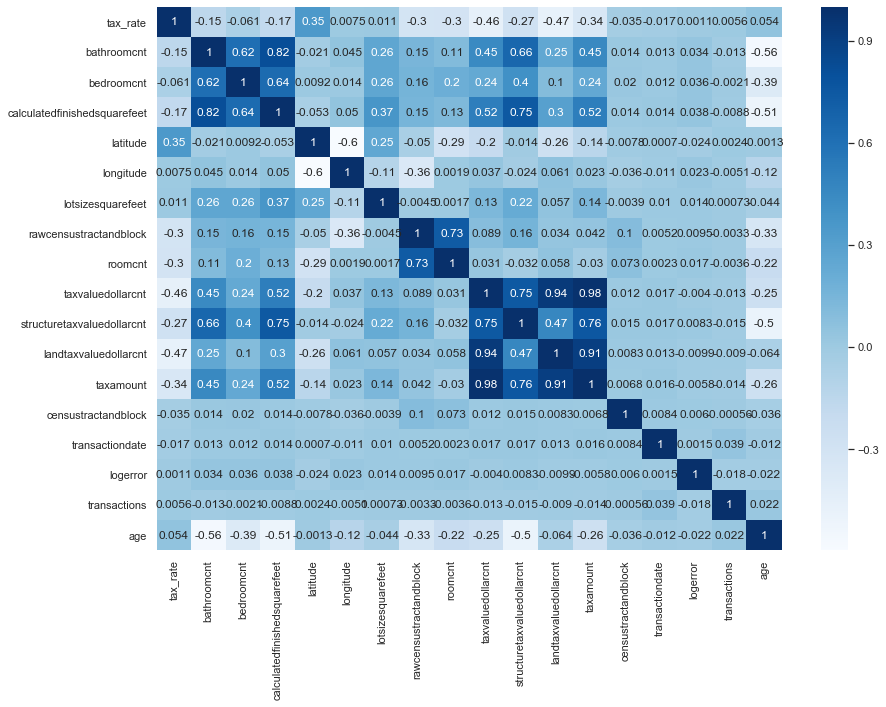

In [46]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap='Blues', annot=True)

In [47]:
train.corr()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,roomcnt,taxvaluedollarcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,transactiondate,logerror,transactions,age
tax_rate,1.00,-0.16,-0.06,-0.18,0.34,0.02,0.01,-0.30,-0.30,-0.47,-0.29,-0.47,-0.36,-0.30,-0.02,0.00,0.01,0.06
bathroomcnt,-0.16,1.00,0.61,0.82,-0.03,0.05,0.26,0.15,0.12,0.45,0.65,0.25,0.45,0.15,0.01,0.03,-0.01,-0.56
bedroomcnt,-0.06,0.61,1.00,0.63,0.01,0.01,0.26,0.16,0.20,0.24,0.40,0.11,0.24,0.16,0.01,0.03,-0.00,-0.38
calculatedfinishedsquarefeet,-0.18,0.82,0.63,1.00,-0.06,0.05,0.37,0.16,0.13,0.52,0.74,0.31,0.52,0.16,0.01,0.04,-0.01,-0.50
latitude,0.34,-0.03,0.01,-0.06,1.00,-0.59,0.26,-0.04,-0.28,-0.20,-0.02,-0.26,-0.15,-0.04,-0.01,-0.03,0.01,0.01
longitude,0.02,0.05,0.01,0.05,-0.59,1.00,-0.11,-0.38,-0.00,0.04,-0.02,0.06,0.03,-0.38,-0.01,0.02,-0.01,-0.13
lotsizesquarefeet,0.01,0.26,0.26,0.37,0.26,-0.11,1.00,-0.00,0.00,0.13,0.22,0.06,0.13,-0.00,0.01,0.01,0.00,-0.04
rawcensustractandblock,-0.30,0.15,0.16,0.16,-0.04,-0.38,-0.00,1.00,0.73,0.09,0.16,0.04,0.05,1.00,0.00,0.01,-0.01,-0.34
roomcnt,-0.30,0.12,0.20,0.13,-0.28,-0.00,0.00,0.73,1.00,0.03,-0.02,0.06,-0.02,0.73,-0.00,0.02,-0.01,-0.23
taxvaluedollarcnt,-0.47,0.45,0.24,0.52,-0.20,0.04,0.13,0.09,0.03,1.00,0.75,0.94,0.98,0.09,0.02,0.00,-0.01,-0.24


**Takeaways:** Nothing huge stands out in regards to correlation with our taget, log error.

**Task:** Look closer at individual features with more visualizations and statistical testing.

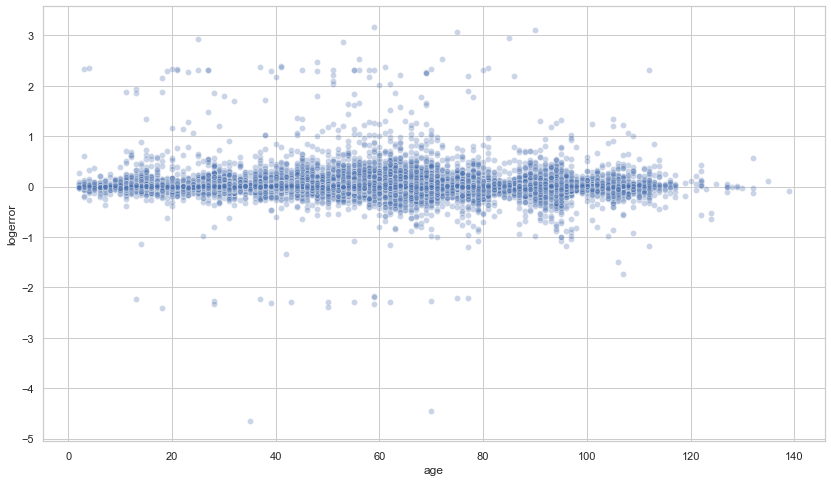

In [48]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='age', y='logerror', data=train, alpha=.3)

In [49]:
r, p = stats.pearsonr(train.age, train.logerror)
print('r:',r, 'p:',p)

r: -0.023391296591064873 p: 1.1760032044885623e-05


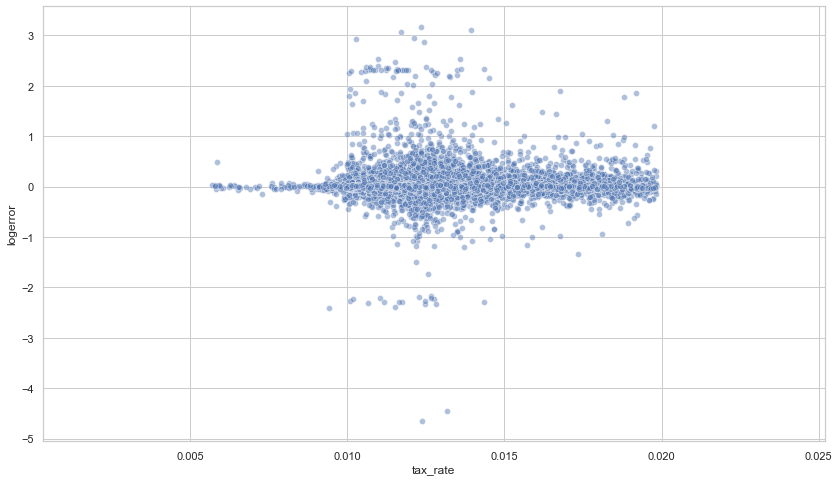

In [50]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='tax_rate', y='logerror', data=train, alpha=.45)

In [51]:
r, p = stats.pearsonr(train.tax_rate, train.logerror)
print('r:',r, 'p:',p)

r: 5.962866949089842e-05 p: 0.9910886439291061


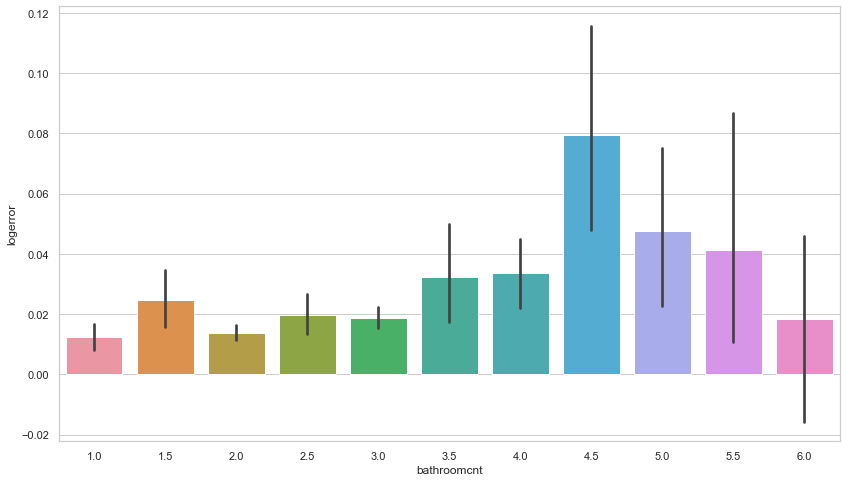

In [52]:
plt.figure(figsize=(14,8))
sns.barplot(x='bathroomcnt', y='logerror', data=train)

In [53]:
r, p = stats.pearsonr(train.bathroomcnt, train.logerror)
print('r:',r, 'p:',p)

r: 0.0344269366245435 p: 1.1157581250136825e-10


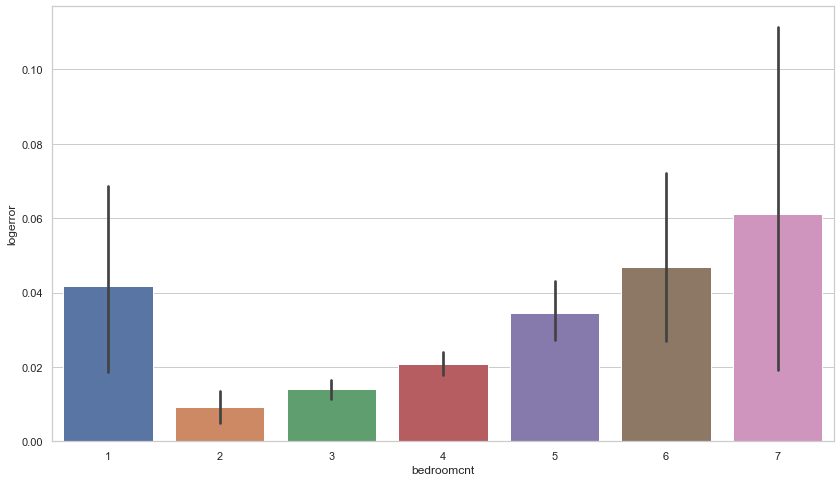

In [54]:
plt.figure(figsize=(14,8))
sns.barplot(x='bedroomcnt', y='logerror', data=train)

In [55]:
r, p = stats.pearsonr(train.bedroomcnt, train.logerror)
print('r:',r, 'p:',p)

r: 0.03368630254077798 p: 2.7630050113503756e-10


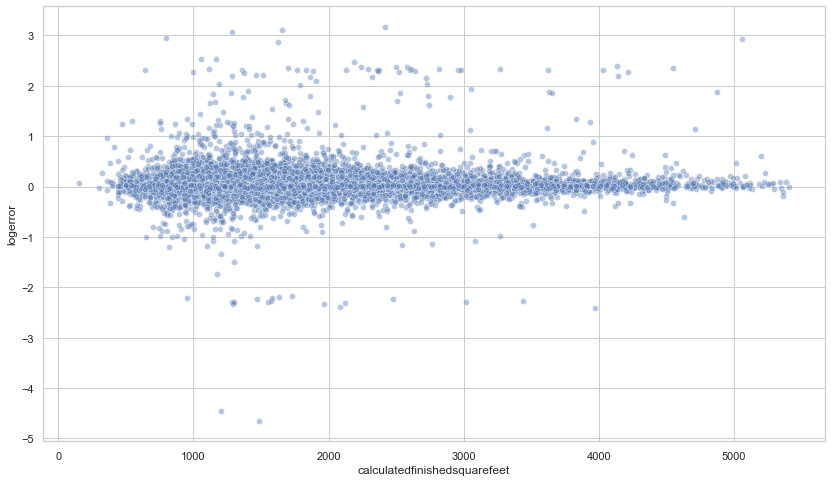

In [56]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='calculatedfinishedsquarefeet', y='logerror', data=train, alpha=.4)

In [57]:
r, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.logerror)
print('r:',r, 'p:',p)

r: 0.03874507300022096 p: 3.8706163630304396e-13


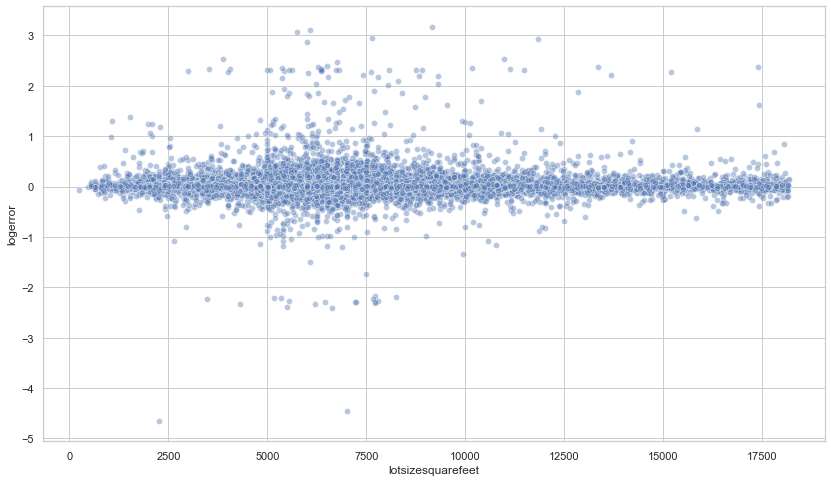

In [58]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='lotsizesquarefeet', y='logerror', data=train, alpha=.4)

In [59]:
r, p = stats.pearsonr(train.lotsizesquarefeet, train.logerror)
print('r:',r, 'p:',p)

r: 0.0102528690237866 p: 0.054794685125985086


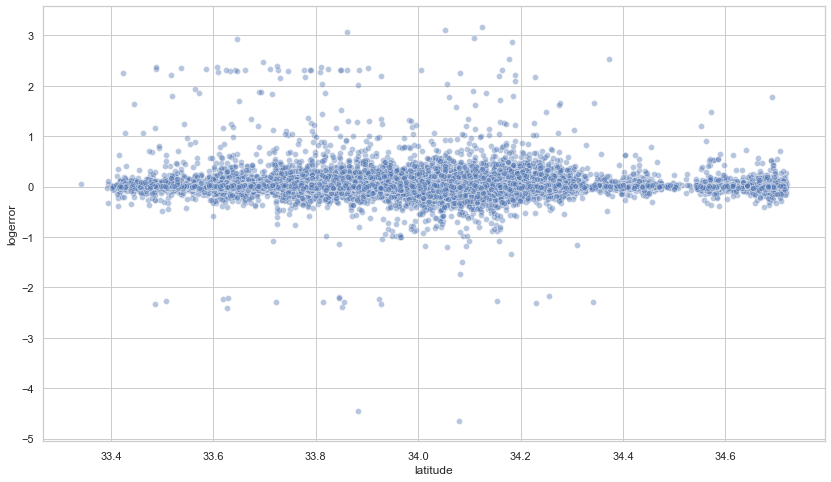

In [60]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='latitude', y='logerror', data=train, alpha=.4)

In [61]:
r, p = stats.pearsonr(train.latitude, train.logerror)
print('r:',r, 'p:',p)

r: -0.025227814058630324 p: 2.2883031354739516e-06


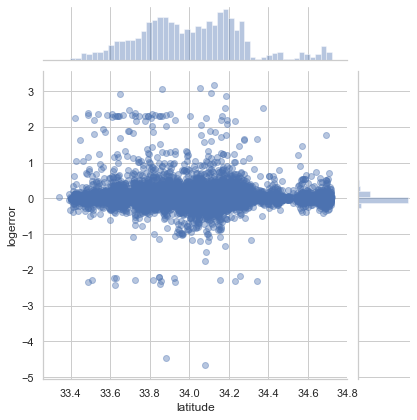

In [62]:
sns.jointplot(x='latitude', y='logerror', data=train, alpha=.4)

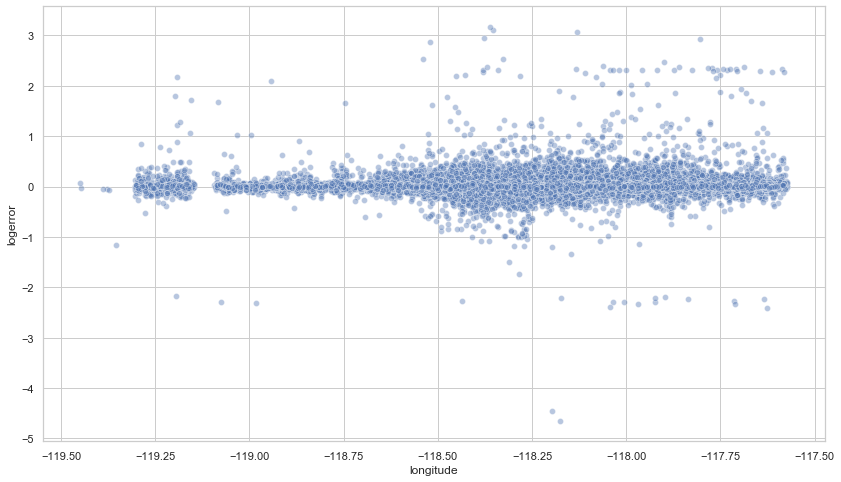

In [63]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='logerror', data=train, alpha=.4)

In [64]:
r, p = stats.pearsonr(train.longitude, train.logerror)
print('r:',r, 'p:',p)

r: 0.01971799065207356 p: 0.0002210078510970351


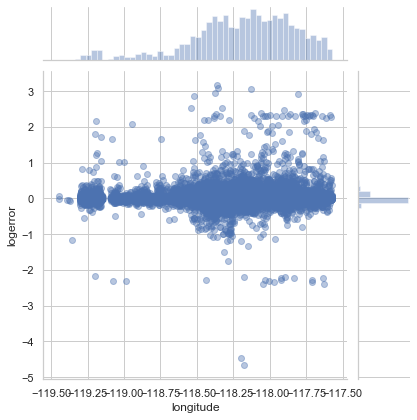

In [65]:
sns.jointplot(x='longitude', y='logerror', data=train, alpha=.4)

In [66]:
# Look at lat and long together in a viz

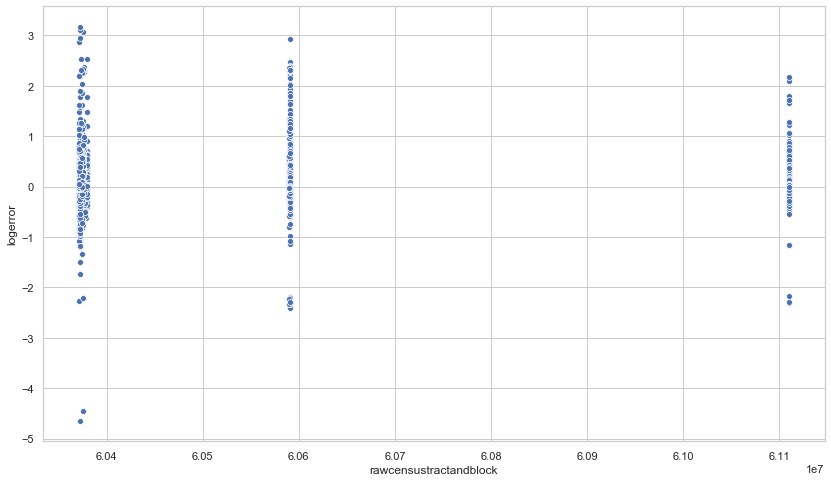

In [67]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='rawcensustractandblock', y='logerror', data=train)

In [68]:
r, p = stats.pearsonr(train.rawcensustractandblock, train.logerror)
print('r:',r, 'p:',p)

r: 0.013905944380453608 p: 0.009192026376165932


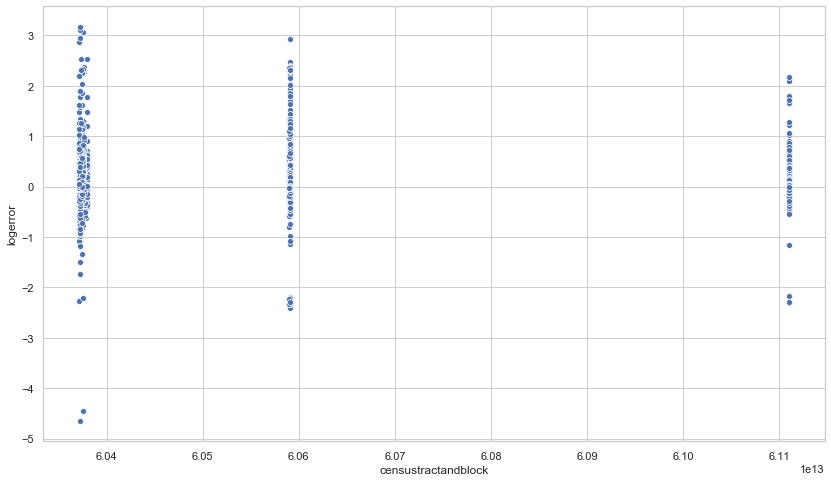

In [69]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='censustractandblock', y='logerror', data=train)

In [70]:
r, p = stats.pearsonr(train.censustractandblock, train.logerror)
print('r:',r, 'p:',p)

r: 0.013906868196030677 p: 0.009187384692522404


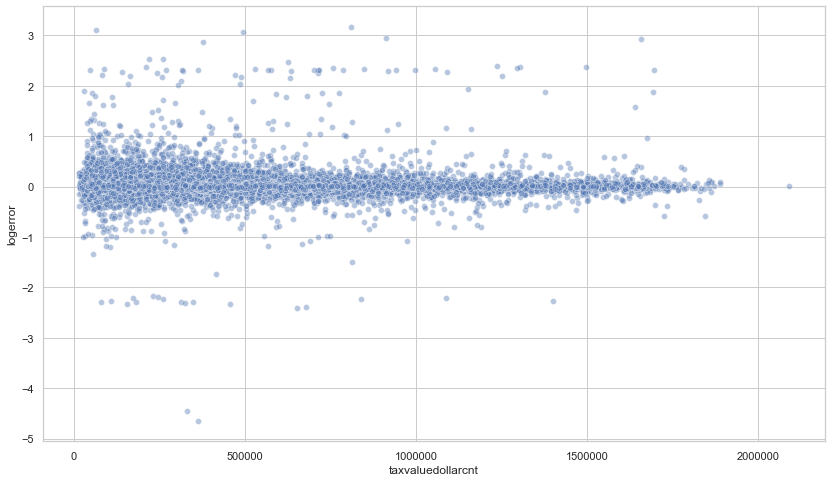

In [71]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='taxvaluedollarcnt', y='logerror', data=train, alpha=.4)

In [72]:
r, p = stats.pearsonr(train.taxvaluedollarcnt, train.logerror)
print('r:',r, 'p:',p)

r: 0.0005476022134499625 p: 0.9183037817905654


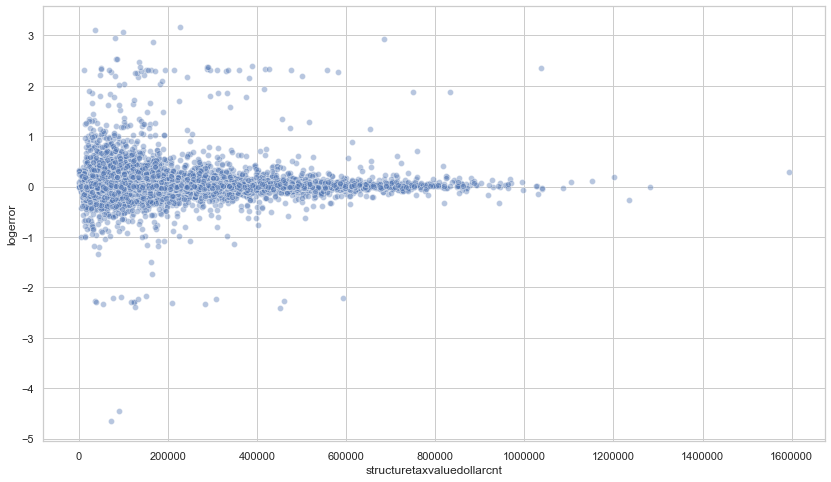

In [73]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='structuretaxvaluedollarcnt', y='logerror', data=train, alpha=.4)

In [74]:
r, p = stats.pearsonr(train.structuretaxvaluedollarcnt, train.logerror)
print('r:',r, 'p:',p)

r: 0.011952388840152421 p: 0.025164713539785034


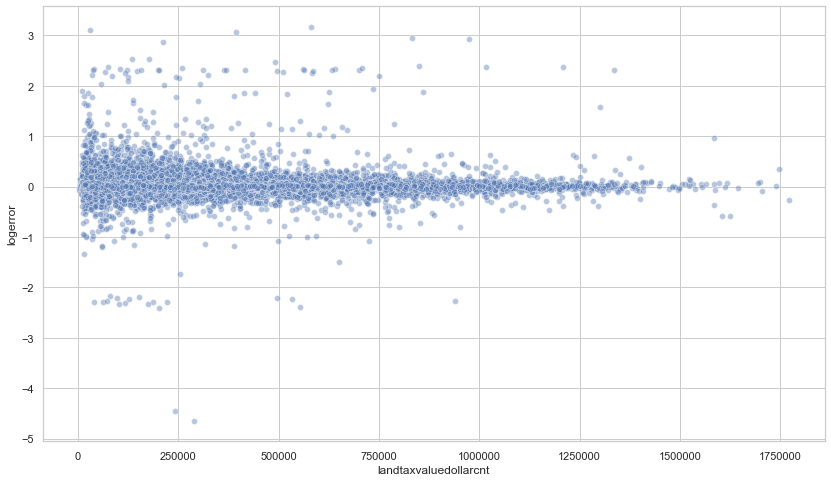

In [75]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='landtaxvaluedollarcnt', y='logerror', data=train, alpha=.4)

In [76]:
r, p = stats.pearsonr(train.landtaxvaluedollarcnt, train.logerror)
print('r:',r, 'p:',p)

r: -0.005521476520572957 p: 0.30102970490872305


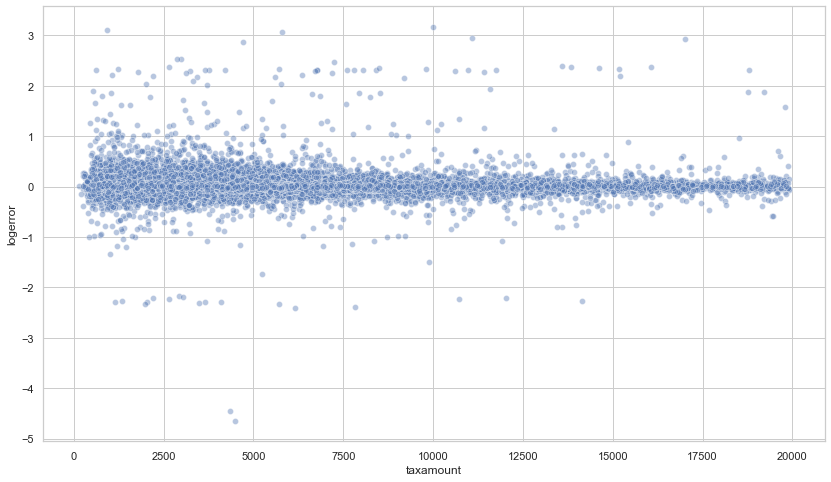

In [77]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='taxamount', y='logerror', data=train, alpha=.4)

In [78]:
r, p = stats.pearsonr(train.taxamount, train.logerror)
print('r:',r, 'p:',p)

r: -0.0015791176697969077 p: 0.7673962224357572


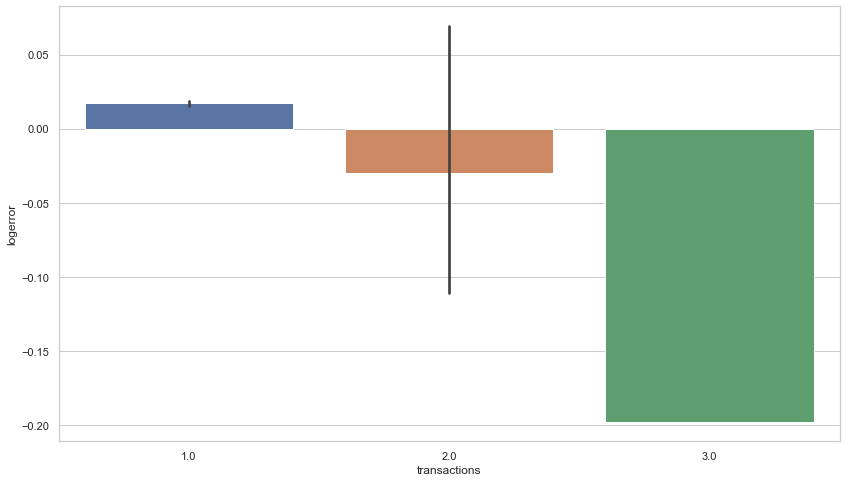

In [79]:
plt.figure(figsize=(14,8))
sns.barplot(x='transactions', y='logerror', data=train)

In [80]:
r, p = stats.pearsonr(train.transactions, train.logerror)
print('r:',r, 'p:',p)

r: -0.013895215628156526 p: 0.009246086167128615


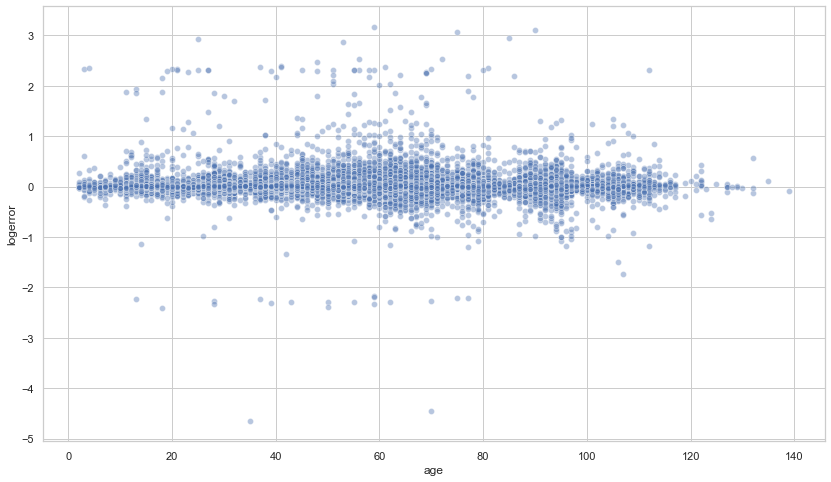

In [81]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=train.age, y=train.logerror, data=train, alpha=.4)

In [82]:
r, p = stats.pearsonr(train.age, train.logerror)
print('r:',r, 'p:',p)

r: -0.023391296591064873 p: 1.1760032044885623e-05


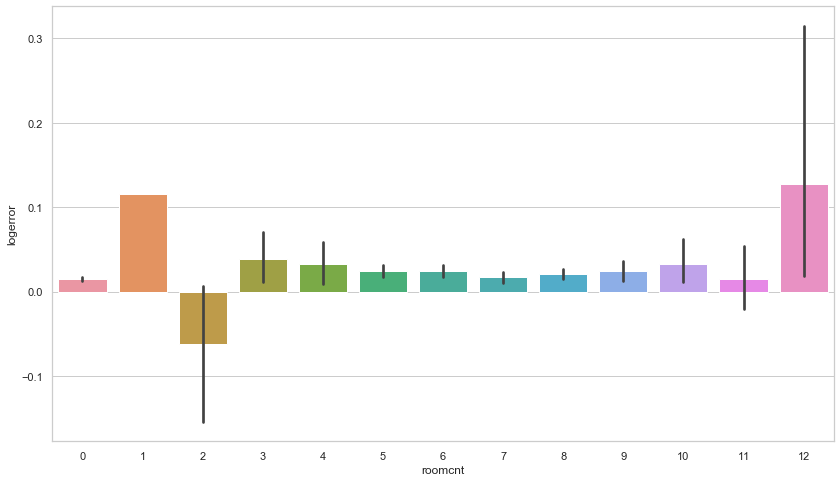

In [83]:
plt.figure(figsize=(14,8))
sns.barplot(x='roomcnt', y='logerror', data=train)

In [84]:
r, p = stats.pearsonr(train.roomcnt, train.logerror)
print('r:',r, 'p:',p)

r: 0.017951201083746558 p: 0.0007718846641929768


In [85]:
# Look at features of a house
# Look at location features of a house
# Look at value features of a house

In [86]:
x_feat = train[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet',  'age']]

Text(0, 0.5, 'Inertia')

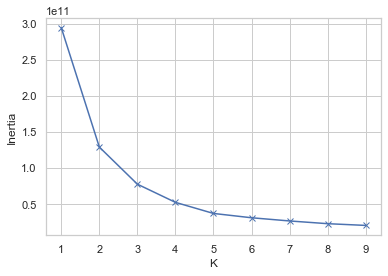

In [87]:
k_values = []
inertias = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(x_feat)
    inertias.append(kmeans.inertia_)
    k_values.append(k)
    
plt.plot(k_values, inertias, marker='x')
plt.xlabel('K')
plt.ylabel('Inertia')

In [88]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(x_feat)
kmeans.predict(x_feat)

array([4, 3, 3, ..., 3, 4, 3], dtype=int32)

In [89]:
# Center points for each cluster
kmeans.cluster_centers_

array([[2.83943577e+00, 3.72088836e+00, 2.57144238e+03, 1.51351879e+04,
        5.03355342e+01],
       [2.06892553e+00, 2.77789230e+00, 1.49077351e+03, 2.92934630e+03,
        4.86289616e+01],
       [2.58640259e+00, 3.59485754e+00, 2.24141093e+03, 1.05066864e+04,
        5.01192958e+01],
       [2.22545742e+00, 3.36884236e+00, 1.82593869e+03, 7.58015236e+03,
        5.48081457e+01],
       [1.96160231e+00, 3.13374233e+00, 1.57200079e+03, 5.70458174e+03,
        5.89839769e+01]])

In [90]:
kmeans.labels_

array([4, 3, 3, ..., 3, 4, 3], dtype=int32)

In [91]:
# sum of squared errors from each data point to the cluster center
kmeans.inertia_

37181278546.97689

In [92]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=x_feat.columns)
centers

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,age
0,2.84,3.72,"2,571.44","15,135.19",50.34
1,2.07,2.78,"1,490.77","2,929.35",48.63
2,2.59,3.59,"2,241.41","10,506.69",50.12
3,2.23,3.37,"1,825.94","7,580.15",54.81
4,1.96,3.13,"1,572.00","5,704.58",58.98


In [93]:
# add viz

In [94]:
x_loc = train[['latitude', 'longitude']]

Text(0, 0.5, 'Inertia')

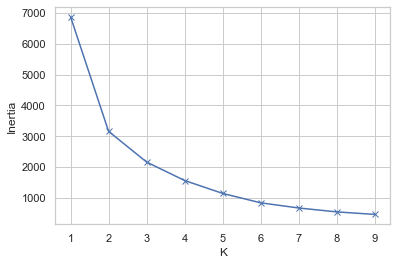

In [95]:
k_values = []
inertias = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(x_loc)
    inertias.append(kmeans.inertia_)
    k_values.append(k)
    
plt.plot(k_values, inertias, marker='x')
plt.xlabel('K')
plt.ylabel('Inertia')

In [96]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(x_loc)
kmeans.predict(x_loc)

array([4, 1, 4, ..., 3, 4, 2], dtype=int32)

In [97]:
# Center points for each cluster
kmeans.cluster_centers_

array([[  33.66270781, -117.77591889],
       [  34.25458196, -118.96040817],
       [  34.11097804, -118.39636263],
       [  34.63386298, -118.15187265],
       [  33.93630267, -118.02202783]])

In [98]:
kmeans.labels_

array([4, 1, 4, ..., 3, 4, 2], dtype=int32)

In [99]:
# sum of squared errors from each data point to the cluster center
kmeans.inertia_

1147.2677349224643

In [100]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=x_loc.columns)
centers

,latitude,longitude
0,33.66,-117.78
1,34.25,-118.96
2,34.11,-118.40
3,34.63,-118.15
4,33.94,-118.02


[None, Text(0.5, 0, 'latitude'), Text(0.5, 0, 'longitude')]

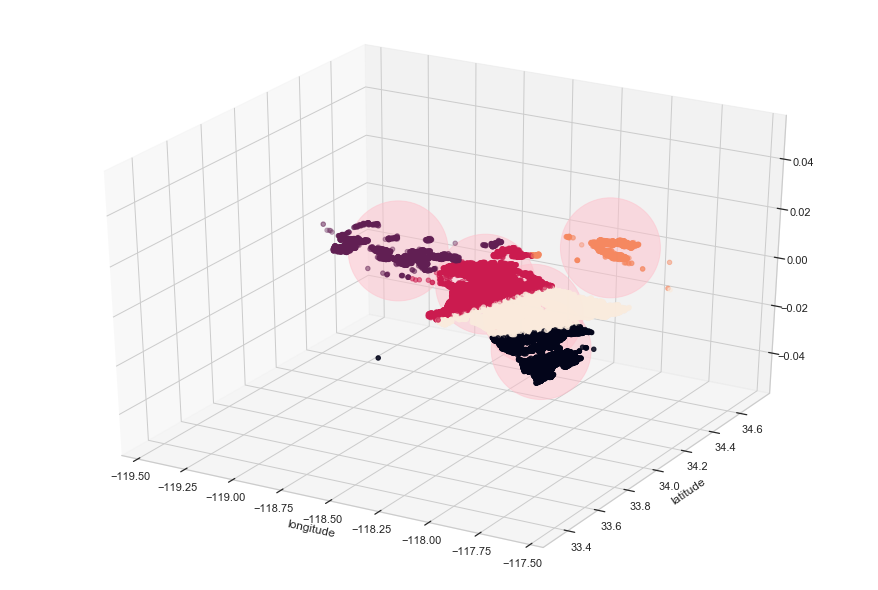

In [101]:
# Fix centers
# dont need 3D
fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig)

ax.scatter(train.longitude, train.latitude, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, c='pink', s=10000, alpha=.5)
ax.set(ylabel='latitude', xlabel='longitude', zorder=-1)

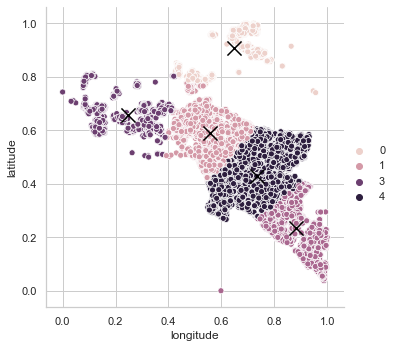

In [102]:
X = train1[['longitude', 'latitude']]

kmeans = KMeans(n_clusters=5, random_state=123).fit(X)

X['cluster'] = 'clusters ' + pd.Series(kmeans.predict(X)).astype(str)

sns.relplot(data=X, hue=kmeans.labels_, x='longitude', y='latitude')
plt.scatter(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], marker='x', s=200, c='black')

In [103]:
# We will be using these clusters to plug into our model
kmeans = KMeans(n_clusters=5, random_state=123).fit(train1[['longitude', 'latitude']])
train1['cluster'] = kmeans.predict(train1[['longitude', 'latitude']])

cluster_0 = train1[train1.cluster == 0]
cluster_1 = train1[train1.cluster == 1]
cluster_2 = train1[train1.cluster == 2]
cluster_3 = train1[train1.cluster == 3]
cluster_4 = train1[train1.cluster == 4]

In [104]:
cluster_0.describe().T
print(cluster_0.shape)
print(cluster_1.shape)
print(cluster_2.shape)
print(cluster_3.shape)
print(cluster_4.shape)

(2255, 26)
(8939, 26)
(7023, 26)
(3003, 26)
(13867, 26)


In [105]:
#Ho: Latitude and longitude have no effect on log error.
r, p = stats.pearsonr(cluster_0.latitude, cluster_0.logerror)
print('latitude','r:',r, 'p:',p)
r, p = stats.pearsonr(cluster_0.longitude, cluster_0.logerror)
print('longitude', 'r:',r, 'p:',p)

latitude r: -0.036163230219266304 p: 0.08599983354194154
longitude r: -0.008400188006387258 p: 0.6901258785207592


#### Will use the above clusters to feed into our model.

In [106]:
x_val = train[['tax_rate', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'transactions']]

Text(0, 0.5, 'Inertia')

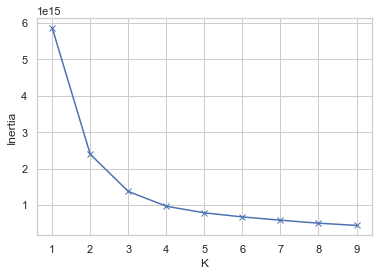

In [107]:
k_values = []
inertias = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(x_val)
    inertias.append(kmeans.inertia_)
    k_values.append(k)
    
plt.plot(k_values, inertias, marker='x')
plt.xlabel('K')
plt.ylabel('Inertia')

### Findings:
- Longitude/latitude definitely have a correlation with log error. Used k=7 for clustering.
- Age does not appear to have a correlation with log error. Maybe drop it?
- Region city does not have a correlation with log error. They are pretty evenly spread out.
- Combine bed/bath count to create a single feature to then work with one column. 
- Drop roomcnt.
- Table Census information 
- Look more into transaction date, maybe treat each data as a categorical var.
- Drop assessmentyear
- Drop property county land use code, using long/lat and have county names already.
- Tax amout/ * tax dollar count relates to log error, maybe not a good feature to use -- keep in mind.
- Add back in outliers in a separate dataframe, and keep a df without outliers to compare differences
- Pick back up some columns and impute (fill in with mean) instead of dropping
- Change outlier function, make k=1.5 instead of 3 (look at both ways) 
- Toy with idea of combining living area feature to create on mega feature
- **After adding back in columns, need to do statistical testing on features with a lot of null values before and after imputing to double check if the impute sways the data greatly one way or another.

#### Cluster Exploration

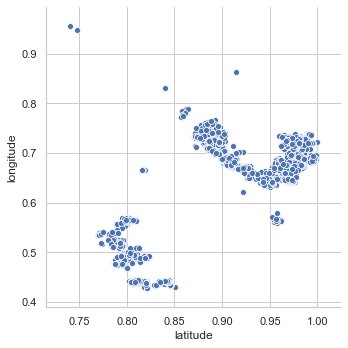

In [108]:
sns.relplot(data=cluster_0, x='latitude', y='longitude')

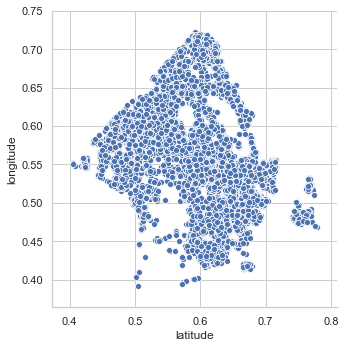

In [109]:
sns.relplot(data=cluster_1, x='latitude', y='longitude')

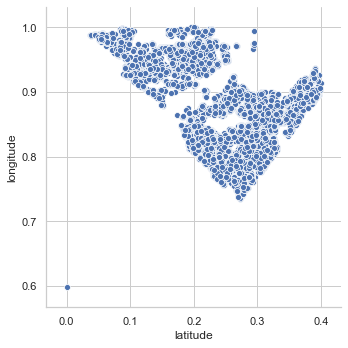

In [110]:
sns.relplot(data=cluster_2, x='latitude', y='longitude')

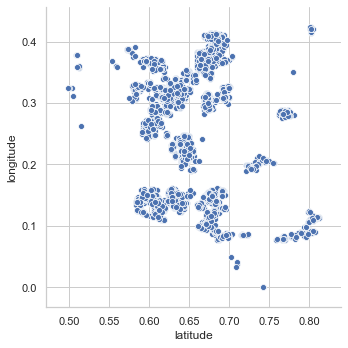

In [111]:
sns.relplot(data=cluster_3, x='latitude', y='longitude')

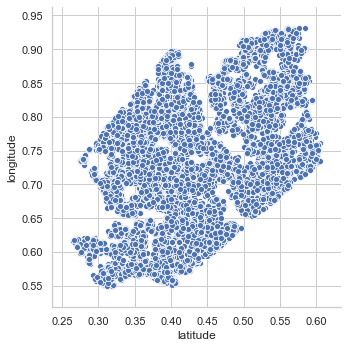

In [112]:
sns.relplot(data=cluster_4, x='latitude', y='longitude')

In [113]:
cluster_0.columns

Index(['county', 'tax_rate', 'fips', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'taxvaluedollarcnt',
       'structuretaxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'transactiondate', 'logerror',
       'transactions', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'age', 'latitude',
       'longitude', 'cluster'],
      dtype='object')

In [114]:
cluster_0.shape

(2255, 26)

In [115]:
train1.cluster.unique()

array([4, 3, 1, 2, 0])

In [116]:
train1.head()

,county,tax_rate,fips,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,taxvaluedollarcnt,...,logerror,transactions,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,age,latitude,longitude,cluster
parcelid,,,,,,,,,,,,,,,,,,,,,
14115188,Orange,0.01,6059,122,"60,590,871.06","16,764.00",1286,"97,021.00",6,"476,345.00",...,-0.01,1.00,-0.21,-0.29,-0.59,-0.16,0.18,0.35,0.81,4
17202081,Ventura,0.01,6111,1111,"61,110,076.10","25,974.00",2061,"97,097.00",7,"269,973.00",...,0.07,1.00,0.39,-0.29,-0.01,-0.05,-1.13,0.67,0.30,3
11867910,Los Angeles,0.01,6037,0100,"60,374,808.04","50,677.00",3101,"96,531.00",0,"92,656.00",...,-0.02,1.00,-1.42,-1.43,-1.34,0.21,1.80,0.55,0.69,4
12888153,Los Angeles,0.01,6037,0100,"60,374,024.02","20,008.00",3101,"96,506.00",0,"288,484.00",...,0.03,1.00,-1.42,-0.29,-0.91,-0.27,0.68,0.51,0.89,4
17055276,Ventura,0.01,6111,1110,"61,110,009.03","13,091.00",2061,"97,099.00",6,"820,000.00",...,0.09,1.00,-0.82,-1.43,-0.62,1.22,1.58,0.80,0.11,3


In [117]:
encode = LabelEncoder()
encode.fit(train1.county)
train1.county = encode.transform(train1.county)
test1.county = encode.transform(test1.county)

In [118]:
train1.head()

,county,tax_rate,fips,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,taxvaluedollarcnt,...,logerror,transactions,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,age,latitude,longitude,cluster
parcelid,,,,,,,,,,,,,,,,,,,,,
14115188,1,0.01,6059,122,"60,590,871.06","16,764.00",1286,"97,021.00",6,"476,345.00",...,-0.01,1.00,-0.21,-0.29,-0.59,-0.16,0.18,0.35,0.81,4
17202081,2,0.01,6111,1111,"61,110,076.10","25,974.00",2061,"97,097.00",7,"269,973.00",...,0.07,1.00,0.39,-0.29,-0.01,-0.05,-1.13,0.67,0.30,3
11867910,0,0.01,6037,0100,"60,374,808.04","50,677.00",3101,"96,531.00",0,"92,656.00",...,-0.02,1.00,-1.42,-1.43,-1.34,0.21,1.80,0.55,0.69,4
12888153,0,0.01,6037,0100,"60,374,024.02","20,008.00",3101,"96,506.00",0,"288,484.00",...,0.03,1.00,-1.42,-0.29,-0.91,-0.27,0.68,0.51,0.89,4
17055276,2,0.01,6111,1110,"61,110,009.03","13,091.00",2061,"97,099.00",6,"820,000.00",...,0.09,1.00,-0.82,-1.43,-0.62,1.22,1.58,0.80,0.11,3


In [119]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35087 entries, 14115188 to 11065285
Data columns (total 26 columns):
county                          35087 non-null int64
tax_rate                        35087 non-null float64
fips                            35087 non-null object
propertycountylandusecode       35087 non-null object
rawcensustractandblock          35087 non-null float64
regionidcity                    35087 non-null object
regionidcounty                  35087 non-null object
regionidzip                     35087 non-null object
roomcnt                         35087 non-null int64
taxvaluedollarcnt               35087 non-null float64
structuretaxvaluedollarcnt      35087 non-null float64
assessmentyear                  35087 non-null object
landtaxvaluedollarcnt           35087 non-null float64
taxamount                       35087 non-null float64
censustractandblock             35087 non-null float64
transactiondate                 35087 non-null int64
logerror     

In [120]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35087 entries, 14115188 to 11065285
Data columns (total 26 columns):
county                          35087 non-null int64
tax_rate                        35087 non-null float64
fips                            35087 non-null object
propertycountylandusecode       35087 non-null object
rawcensustractandblock          35087 non-null float64
regionidcity                    35087 non-null object
regionidcounty                  35087 non-null object
regionidzip                     35087 non-null object
roomcnt                         35087 non-null int64
taxvaluedollarcnt               35087 non-null float64
structuretaxvaluedollarcnt      35087 non-null float64
assessmentyear                  35087 non-null object
landtaxvaluedollarcnt           35087 non-null float64
taxamount                       35087 non-null float64
censustractandblock             35087 non-null float64
transactiondate                 35087 non-null int64
logerror     

In [121]:
train1['age'] = train1['age'].astype(int)
train1['lotsizesquarefeet'] = train1['lotsizesquarefeet'].astype(int)
train1['calculatedfinishedsquarefeet'] = train1['calculatedfinishedsquarefeet'].astype(int)
train1['bedroomcnt'] = train1['bedroomcnt'].astype(int)
train1['bathroomcnt'] = train1['bathroomcnt'].astype(int)

In [122]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35087 entries, 14115188 to 11065285
Data columns (total 26 columns):
county                          35087 non-null int64
tax_rate                        35087 non-null float64
fips                            35087 non-null object
propertycountylandusecode       35087 non-null object
rawcensustractandblock          35087 non-null float64
regionidcity                    35087 non-null object
regionidcounty                  35087 non-null object
regionidzip                     35087 non-null object
roomcnt                         35087 non-null int64
taxvaluedollarcnt               35087 non-null float64
structuretaxvaluedollarcnt      35087 non-null float64
assessmentyear                  35087 non-null object
landtaxvaluedollarcnt           35087 non-null float64
taxamount                       35087 non-null float64
censustractandblock             35087 non-null float64
transactiondate                 35087 non-null int64
logerror     

In [123]:
# Decision Tree Regressor
x_train1 = train1[['county', 'age', 'cluster', 'transactiondate', 'bedroomcnt', 'bathroomcnt', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet']]
y_train1 = train1[['logerror']]
#x = test1[['county', 'age', 'cluster', 'transactiondate', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt']]
#y = test1[['logerror']]

In [124]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=10, random_state=123)
regressor.fit(x_train1, y_train1)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=123, splitter='best')

In [125]:
y_pred = regressor.predict(x_train1)
y_pred[0:5]

array([ 0.01617314,  0.00381442, -0.00480573,  0.01617314, -0.00480573])

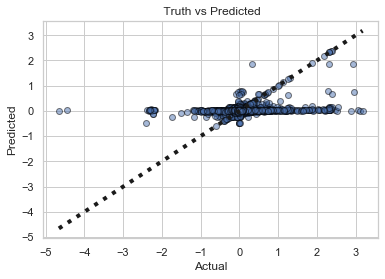

In [126]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_train1, y_pred, edgecolors=(0, 0, 0), alpha=.5)
ax.plot([y_train1.min(), y_train1.max()], [y_train1.min(), y_train1.max()], 'k:', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title(" Truth vs Predicted")
plt.show()

In [127]:
#clf = DecisionTreeClassifier(criterion='entopy', max_depth=5, random_state=123)

In [129]:
#clf.fit(x_train1, y_train1)

In [ ]:
#logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')

In [ ]:
#logit.fit(x_train1, y_train1)

In [ ]:
# price per squarefoot column

Regression algorithms:
- decision tree regression
- logistic regression
- linear regression
- polynimial regression
- ridge regression
- lasso regression
